# 🌍 The Local Geomagnetic Field (and an Introduction to Python)

Throughout the semester, we will use **Jupyter Notebooks** to explore concepts in geomagnetism and paleomagnetism.

A Jupyter notebook is a useful file format that blends narrative text (like this cell) with executable code. This allows us to intersperse explanations, code, and output within a single document.

### ⚡ Using Google Colab
We are running these notebooks in the cloud using **Google Colab**.
* **The Benefit:** You don't need to install complex software today. Google's servers handle the heavy lifting.
* **The Quirk (Important!):** Colab instances are "stateless." Think of them as having the memory of a goldfish. If you close this tab or disconnect, the "computer" resets.
    * **Implication:** We must reinstall our specific tools (like `pmagpy`) at the top of every session.
    * **Saving Work:** To save your progress, you must click **File > Save a copy in Drive** immediately, or your edits will be lost when you close the browser.

### 🧭 Today's Scientific Goal: The IGRF
This week, we are investigating the geomagnetic field. We will use Python to query the **International Geomagnetic Reference Field (IGRF)**.

The IGRF is a mathematical model that describes the large-scale structure of the Earth's main magnetic field and its secular variation. We will calculate the local field vector for specific locations and explore how the field geometry changes across the globe.

### 🚀 Getting Started
Execute the "Setup Cell" below by clicking the **Play button (▶)** on the left side of the cell (or press Shift+Enter). This will install the necessary paleomagnetism software packages for this session.

## Install and then import packages to your local Colab environment

In [1]:
print("⏳ Installing PmagPy and Cartopy... (this may take a moment)")
# We use --quiet to keep the output clean
!pip install pmagpy cartopy --quiet

# Standard imports for data science
import numpy as np
import matplotlib.pyplot as plt

# PmagPy imports
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

# Cartopy (map plotting)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("✅ Installation and imports complete! You are ready to go.")

⏳ Installing PmagPy and Cartopy... (this may take a moment)
✅ Installation and imports complete! You are ready to go.


# 🐍 Python Concepts: Functions & Documentation

Before we calculate the magnetic field, we need to understand a core concept in Python: **Functions**.

### What is a Function?
Think of a function as a small machine or a recipe.
1.  **Input:** You give it specific ingredients (called **arguments** or **parameters**).
2.  **Processing:** It performs a specific task behind the scenes.
3.  **Output:** It gives you back a result (called the **return value**).

### Inspecting Functions (The `?` Magic)
We are going to use a function from the PmagPy library called `ipmag.igrf` to calculate the magnetic field. But how do we know what "ingredients" it needs?

In Jupyter/Colab, you can ask for the "User Manual" (Docstring) by adding a question mark `?` after the function name and running the cell.

### 📖 The `ipmag.igrf` Docstring
When you run the code cell below (`ipmag.igrf?`), a window will pop up with the function's signature. Here is a breakdown of the critical information you will see:

* **What it does:** Determines declination, inclination, and intensity from a geomagnetic field model (default is IGRF).
* **The Inputs (`input_list`):** It requires a list containing four specific numbers:
    * **Date:** Decimal year (e.g., `2023.5` for mid-2023).
    * **Altitude:** In kilometers (use `0` for sea level).
    * **Latitude:** Degrees North (+90 to -90).
    * **Longitude:** Degrees East (0 to 360 or -180 to +180).
* **The Output:** It returns an array with three values: `[Declination, Inclination, Intensity]`.

Let's take a look at the official documentation now.

In [2]:
ipmag.igrf?

# 📦 Python Concepts: Variables

To make our code readable and reusable, we store values in **variables**. You can think of a variable as a labeled box where we keep a specific piece of information. Instead of typing the number `2025` every time we need the date, we can type the word `date`.

### Defining our Location
We need to define the four parameters required by the IGRF model. We will assign each one to a variable in the code cell below.

* **`date`**: The time of interest in decimal years (e.g., `2026.0`).
* **`altitude`**: Height above the surface in kilometers (km).
* **`latitude`**: Degrees North ($-90$ to $+90$).
* **`longitude`**: Degrees **East**.
    * *Note:* If you are looking for a location in the Western Hemisphere (like the Americas), you have two options:
        1.  Use a **negative** number (e.g., `-93.27`).
        2.  Subtract the value from 360 (e.g., `360 - 93.27`).

In the next cell, we will define our parameters.

In [3]:
date = 2026.0
altitude = 0.3
latitude = 44.98
longitude = -93.27


### 🗺️ Sanity Check: Visualizing the Location

Before we ask the IGRF model for the magnetic field vector, it is good practice to verify that our coordinate variables actually point to where we think they do!

In the cell below, we will use **Cartopy** (a Python library for geospatial data processing) to create a simple map and plot a red marker at the `latitude` and `longitude` coordinates we just defined.

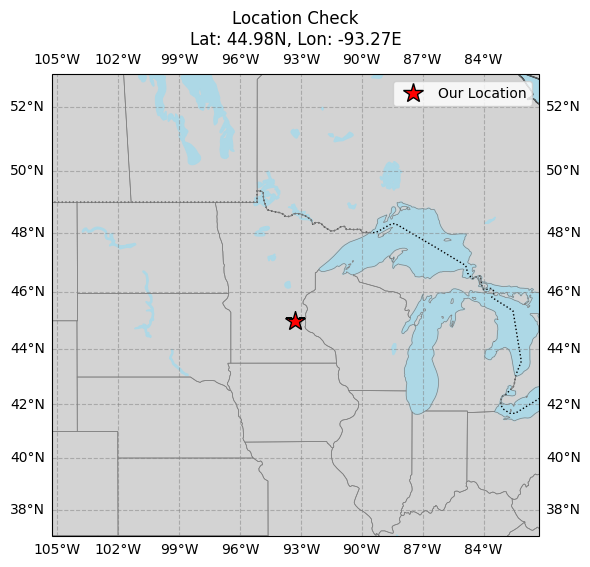

In [4]:

# 1. Setup Figure and Axes (we create an 'ax' object to modify)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mercator())

# 2. Add geographic features to 'ax'
ax.add_feature(cfeature.LAND, color='lightgrey')
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.LAKES, color='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, color='gray')

# 3. Plot Location on 'ax'
ax.plot(longitude, latitude, 'r*', markersize=15, markeredgecolor='k',
        label='Our Location', transform=ccrs.PlateCarree())

# 4. Zoom and put on title and legend
ax.set_extent([longitude - 12, longitude + 12, latitude - 8, latitude + 8],
              crs=ccrs.PlateCarree())
ax.set_title(f"Location Check\nLat: {latitude}N, Lon: {longitude}E")
ax.legend()

plt.show()

# 🧲 Calculating the Magnetic Field Vector

Now that we have verified our location coordinates on the map, we are ready to query the IGRF model to find the magnetic field vector.

### 1. Preparing the Input
As we saw in the documentation earlier, the `ipmag.igrf` function does not accept the four parameters as separate arguments. Instead, it expects a **single list** containing them in a specific order:
`[date, altitude, latitude, longitude]`

In the code below, we will first "pack" our variables into a list called `igrf_list`.

### 2. Interpreting the Output
The function returns an array containing three specific values. It is important to know which is which:
1.  **Declination ($D$):** The angle (in degrees) relative to True North.
2.  **Inclination ($I$):** The angle (in degrees) relative to the horizontal (positive numbers point **down**).
3.  **Intensity ($F$):** The strength of the field in **nanoTesla (nT)**.

Run the cell below to perform the calculation.

In [5]:
igrf_list = [date, altitude, latitude, longitude]
igrf_values = ipmag.igrf(igrf_list)
print(igrf_values)

model not available past 2025
[ 0. nan  0.]


# 📦 Python Concepts: List Indexing

We now have a variable called `igrf_values` that contains our three results, but they are stuck inside a single list (or array). To use them individually, we need to extract them.

In Python, we access specific items in a list using their **Index**.

### ⚠️ The "Zero-Based" Rule
Crucially, Python starts counting at **0**, not 1.
* **1st Item:** Index `[0]`
* **2nd Item:** Index `[1]`
* **3rd Item:** Index `[2]`

According to the documentation we read earlier, the `ipmag.igrf` function outputs the data in this order: **[Declination, Inclination, Intensity]**.

In the cell below, we will "unpack" these values into three separate variables with clear names so we can easily use them in our equations later.

In [6]:
# Extract individual values using their index
IGRF_dec = igrf_values[0]       # 1st item (Declination)
IGRF_inc = igrf_values[1]       # 2nd item (Inclination)
IGRF_intensity = igrf_values[2] # 3rd item (Intensity in nT)

# Print them out nicely to verify
print(f"Declination: {IGRF_dec:.2f} degrees")
print(f"Inclination: {IGRF_inc:.2f} degrees")
print(f"Intensity:   {IGRF_intensity:.1f} nT")

Declination: 0.00 degrees
Inclination: nan degrees
Intensity:   0.0 nT


# 🧲 Theory vs. Model: The Time-Averaged GAD

We calculated the local magnetic field using the **IGRF**, which is a complex mathematical model (spherical harmonic expansion) describing the Earth's full magnetic field.

### The Dipole vs. Non-Dipole Field
Mathematically, we can break the Earth's field down into different components (Gauss coefficients):
* **The Axial Dipole ($g_1^0$):** This single term accounts for about 90% of the Earth's magnetic field at the surface. It represents a dipole aligned with the rotation axis.
* **The Non-Dipole Field:** All other terms (equatorial dipoles $g_1^1, h_1^1$; quadrupoles $n=2$; octupoles $n=3$, etc.) describe the remaining 10%. These account for the tilt of the magnetic pole and complex regional anomalies.

### The "GAD" Hypothesis
A fundamental baseline in paleomagnetism is the **Time-averaged Geocentric Axial Dipole (GAD)** hypothesis. The hypothesis is that when averaged over a sufficient timescale ($>$10,000 years) the field appears to be produced only by the $g_1^0$ term.
1.  **Geocentric:** The source is at the exact center of Earth.
2.  **Axial:** The field is symmetric about the geographic rotation axis.
3.  **Dipole:** It has two poles (North and South).

<img src="https://github.com/Institute-for-Rock-Magnetism/2026_ESCI_pmag_course/raw/9a5c41ebdbd7474ad0ea081e411abaf96624cd49/W1_geomagnetism/images/dipole.png?raw=true" alt="Geocentric Axial Dipole Diagram" width="600"/>

*A schematic of the Geocentric Axial Dipole (GAD). Green lines show the magnetic field geometry. Notice how the inclination (dip) of the field vector changes with latitude, being horizontal at the equator (Site 1) and vertical at the pole (Site 4).*

### The Dipole Equation
In this ideal GAD model, the field geometry is determined entirely by latitude:
* **Declination ($D$):** Is always 0° (compasses point to True North).
* **Inclination ($I$):** Varies with latitude ($\lambda$) according to the dipole Eequation:

$$\tan(I) = 2 \tan(\lambda)$$

### 🧪 The Comparison
In the next cell, we will calculate the expected inclination for a perfect GAD field at our latitude. We will use the helper function `ipmag.inc_from_lat()` which implements the dipole equation.

In [7]:
gad_dec = 0
gad_inc = ipmag.inc_from_lat(latitude)
gad_inc


np.float64(63.4189454709539)

# 📦 Python Concepts: What is `np.float64`?

If you ran the cell above, you probably saw an output that looked something like this:
`np.float64(63.4189...)`

This looks complicated, but it is just Python being very precise about what type of data this is.

* **`float`:** Short for "floating-point number." This is computer-speak for a decimal number (like 63.4) as opposed to a whole number (like 63) which is an **`int`:**.
* **`np`:** This tells us the number was created by the **NumPy** library.
* **`64`:** This refers to the **precision**. It uses 64 bits of computer memory to store the number, allowing it to be extremely accurate (many decimal places).

While `np.float64` is great for calculation, it isn't very pretty to read. In the next cell, we will use an f-string (formatted string) to round it to two decimal places and print it clearly. Let's also compared to the actual IGRF that we calculated before.

In [8]:
print(f"Theoretical GAD Inc:   {gad_inc:.2f}°")
print(f"Actual IGRF Inc:       {IGRF_inc:.2f}°")

Theoretical GAD Inc:   63.42°
Actual IGRF Inc:       nan°


# 🧭 Visualizing the Field: The Stereonet

We now have two different magnetic vectors:
1.  **The Ideal Model (GAD):** What the field *should* be if Earth were a simple bar magnet.
2.  **The Actual Field (IGRF):** What the field *actually* is today.

It is informative to visualize these 3D vectors on an 2D **Equal Area Stereonet**.

### How to Read a Stereonet
Imagine looking down into a hemispherical bowl.
* **The Rim (Edge):** Represents the horizon (Inclination = 0°).
* **The Center:** Represents straight down (Inclination = 90°).
* **Compass Direction:** North is at the top, East is to the right.

So, a point near the **center** means the magnetic field is pointing steeply down into the Earth. A point near the **edge** would mean the field is nearly horizontal.

### The Code
We will use two functions to build this plot:
* `ipmag.plot_net()`: Draws the "skeleton" grid lines.
* `ipmag.plot_di(dec, inc)`: Plots a specific **D**eclination/**I**nclination pair on that grid.

Run the cell below to see how our Local Field (Blue Square) compares to the Ideal GAD Field (Red Star).

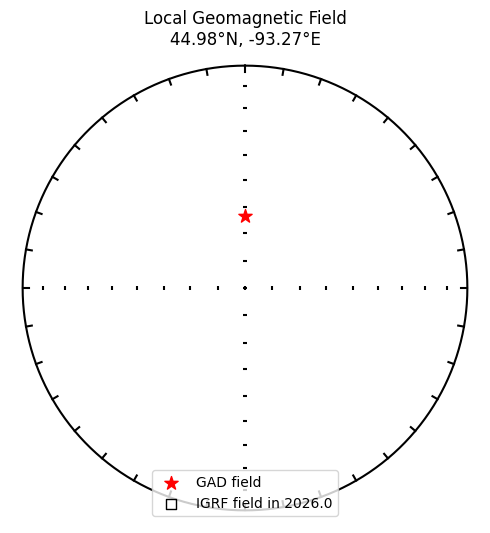

In [9]:
# 1. Setup the stereonet grid
plt.figure(figsize=(5, 5))
ipmag.plot_net()

# 2. Plot the theoretical GAD Vector (Red Star)
ipmag.plot_di(gad_dec, gad_inc, color='red', marker='*', markersize=100,
              label='GAD field')

# 3. Plot the actual IGRF Vector (Blue Square)
ipmag.plot_di(IGRF_dec, IGRF_inc, color='blue', marker='s', markersize=50,
              label=f'IGRF field in {date}')

# 4. Add labels and show
plt.legend(loc='lower center')
plt.title(f'Local Geomagnetic Field\n{latitude}°N, {longitude}°E')
plt.show()

# 🏋️ Exercise: Your Magnetic Birthday

Now it is your turn!

Your task is to determine the magnetic field vector at the **location and time of your birth** and compare it to the ideal GAD hypothesis.

### Instructions
1.  **Define your variables:** In the cell below, enter the latitude, longitude, and year of your birth.
    * *Tip: For the date, use a decimal. If you were born in June 1998, use `1998.5`.*
2.  **Map Check:** Copy the map plotting code to verify your location.
    * *Why? It is very easy to mix up Lat/Lon or forget that "West" means negative longitude!*
3.  **Calculate the IGRF Field:** Copy the code we wrote earlier to pack the list and run `ipmag.igrf`.
4.  **Calculate the GAD Field:** Copy the code using `ipmag.inc_from_lat` to find the expected inclination.
5.  **Visualize:** Copy the plotting code to create a stereonet comparing your specific `IGRF` result (Blue Square) to the `GAD` result (Red Star).
6.  **Submit:**
    * Run the cell to generate the plots.
    * Right-click the images and select **"Save Image As..."**
    * Upload these images to the Canvas assignment.

In [10]:
# 1. Define your birth parameters
# Replace these values with your own!
birth_lat = 44.97     # Latitude (Degrees North)
birth_lon = -93.26    # Longitude (Degrees East)
birth_date = 2000.5   # Date (Decimal Year)
birth_alt = 0         # Altitude (keep at 0 km)

In [10]:
# ------------------------------------------------------------------
# 2. Map Check
# (Copy the code from the 'Defining our Location' section)
# HINT: Update the plot and set_extent variables to use birth_lon and birth_lat!


In [10]:
# ------------------------------------------------------------------
# 3. Calculate Actual Field (IGRF)
# (Copy the code from the 'Calculating the Magnetic Field' section)
# HINT: Remember to pack the list: [date, alt, lat, lon]

In [ ]:
# ------------------------------------------------------------------
# 4. Calculate Expected Field (GAD)
# (Copy the code using ipmag.inc_from_lat)

In [ ]:
# ------------------------------------------------------------------
# 5. Plot the Stereonet
# (Copy the code from the 'Visualizing the Field' section)
# IMPORTANT: Update the variables in ipmag.plot_di() to match your new birth variables!